# Final Project for DTSA-5509

Kevin Juandi <br> 2023-10-09

## Introduction and Problem Description

Welcome to my final project for DTSA-5509! Before running this notebook, please ensure you have all required dependancies installed in your build. All required packages are listed in the next section.

I previously worked in cardiology research and is looking for opportunities to work in healthcare. With that in mind, I look for a related topic to my previous background and stumbled upon this dataset on [Kaggle](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)<sup>[1]</sup>. The dataset itself is a compilation of two famous datasets in heartbeat classification, the [MIT-BIH Arrhythmia Dataset](https://www.physionet.org/content/mitdb/1.0.0/)<sup>[2]</sup> and the [PTB Diagnostic ECG Database](https://www.physionet.org/content/ptbdb/1.0.0/)<sup>[3]</sup>. The dataset is unfortunately too large to be included in the repo.

The purpose of this project is to train classification algorithm in attempt to predict various types of cardiac arrhythmias based on ECG Data.

An ECG (Electrocardiogram) is a medical test that measures the electrical signals of the heart and is essential for diagnosing many cardiac diseases. A healthy individual's heartbeat on an ECG is characterized by a distinctive waveform, representing normal functioning of the heart.

However, when the heart is not functioning optimally, the ECG detects distortions in the anticipated waveform, severe and life-threatening arrhythmias might present a different or nonexistent waveform altogether.

This project attempts to use machine learning techniques to classify ECG data as either healthy or as one of four different kinds of arrhythmia.

Each observation in the dataset represents a single heartbeat on an ECG and is sampled at 125 Hz with 187 total points per observation (~1.5 seconds per observation). These time series points serve as the features of our dataset. Many of these heartbeats are padded with zeros at the end if they lasted for less than 1.5 seconds. Each observation is classified into one of five categories: 0=Normal, 1=Atrial Premature, 2=Premature ventricular contraction, 3=Fusion of ventricular and normal, 5=Unclassifiable.

Without further ado, let us begin working

## Loading dependancies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, precision_score, recall_score, accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
%matplotlib inline

## Helper functions

In [44]:
def train_model(model, X_train, y_train, cv_type, name, **cv_kwargs):
    """Trains a machine learning model using the provided training data and cross validation search type.
    The best model is saved to file with the given name. If that file already exists, this function simply loads it"""
    file_name = f"./{name}.pkl"
    
    if os.path.isfile(file_name):
        model = joblib.load(file_name)
    else:
        if cv_type == "grid":
            model = GridSearchCV(model, **cv_kwargs)
        else:
            model = RandomizedSearchCV(model, **cv_kwargs)
        
        model.fit(X_train, y_train)

        joblib.dump(model, file_name)
    
    print("Best Model Parameters")
    print(model.best_params_)
    
    return model

def make_confusion_matrix(model, X, y):
    """Display the confusion matrix of a model's predictions of given data. Also display Macro F1 Score."""
    
    yhat = model.predict(X)
    
    f1 = f1_score(y_test, yhat, average="macro")
    print(f"Macro F1 Score = {f1}")
    
    cm = ConfusionMatrixDisplay(confusion_matrix(y, yhat))
    cm.plot()
    
def add_to_model_summary_df(summary_df, model, model_name, X_test, y_test):
    """Compiles the results of many machine learning models into a single dataframe for easy analysis"""
    if summary_df is None:
        summary_df = pd.DataFrame(columns=["Name", "Accuracy", "Precision", "Recall", "Macro F1", "Train Time"])
        
    y_test_pred = model.predict(X_test)
    
    model_summary_dict = {"Name": [model_name],
                          "Accuracy": [accuracy_score(y_test, y_test_pred)],
                          "Precision": [precision_score(y_test, y_test_pred, average="macro")],
                          "Recall": [recall_score(y_test, y_test_pred, average="macro")],
                          "Macro F1": [f1_score(y_test, y_test_pred, average="macro")],
                          "Train Time": [np.sum(model.cv_results_["mean_fit_time"])]}
    
    return pd.concat([summary_df, pd.DataFrame(model_summary_dict)], ignore_index=True)

## Load the data

like most dataset on Kaggle, this data is already pre-separated into training and test set. However, column labels aren't provided so we would just label the, as their point number in time series

In [2]:
data_file_train = ".\data\mitbih_train.csv"
data_file_test = ".\data\mitbih_test.csv"

column_names = [f"Point {i+1}" for i in range(187)] + ["label"]
df_train = pd.read_csv(data_file_train, names=column_names)
df_test = pd.read_csv(data_file_test, names=column_names)

df_train["label"] = df_train["label"].astype(int)
df_test["label"] = df_test["label"].astype(int)

df_train.head()

,Point 1,Point 2,Point 3,Point 4,Point 5,Point 6,Point 7,Point 8,Point 9,Point 10,...,Point 179,Point 180,Point 181,Point 182,Point 183,Point 184,Point 185,Point 186,Point 187,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
df_train.dtypes.value_counts()

float64    187
int32        1
dtype: int64

This confirms that we have 187 rows of data and an integer output label for each rows. Let us then take a look of the data shape.

In [42]:
print(f"Train Dataframe Shape = {df_train.shape}")
print(f"Test Dataframe Shape = {df_test.shape}")

Train Dataframe Shape = (87554, 188)
Test Dataframe Shape = (21892, 188)


Drop the label column and check if all the points are between 0 and 1

In [41]:
df_train.drop(columns='label')[(0 <= df_train) & (df_train <= 1)].isna().sum().sum()

0

In [43]:
df_test.drop(columns='label')[(0 <= df_test) & (df_test <= 1)].isna().sum().sum()

0

Every feature in this dataset is numeric and strictly between 0 and 1. The target variable is a categorical variable encoded as in integer

## Preprocessing

This is a very large dataset and it would be impractical to train a model with my laptop due to the expensive training costs. Because of this, both the train and test data will be down sampled by 10x in order to create a smaller dataset to work with.

Firstly, let us visualize the distribution of different classes in the train and test data.

Text(0.5, 1.0, 'Test Data Label Distribution')

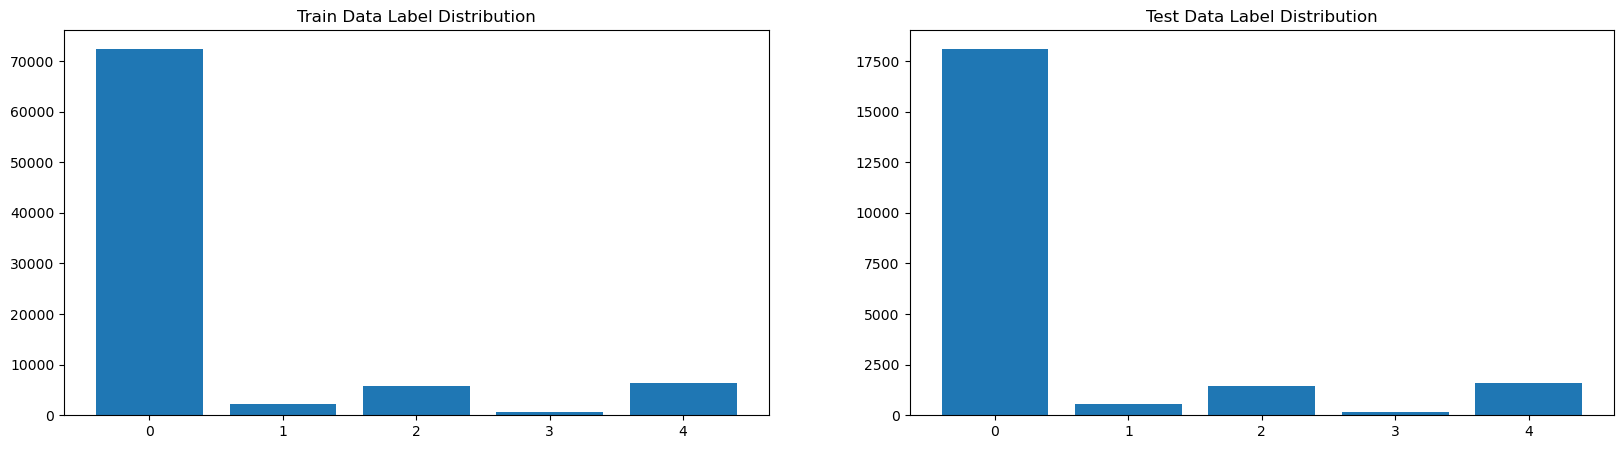

In [45]:
train_value_counts = df_train["label"].value_counts()
test_value_counts = df_test["label"].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].bar(train_value_counts.index, train_value_counts.values)
axs[0].set_title("Train Data Label Distribution")
axs[1].bar(test_value_counts.index, test_value_counts.values)
axs[1].set_title("Test Data Label Distribution")

In [46]:
print("Class Proportions")
train_value_counts / np.sum(train_value_counts)

Class Proportions


0    0.827729
4    0.073452
2    0.066108
1    0.025390
3    0.007321
Name: label, dtype: float64

In [48]:
print("Class Proportions")
test_value_counts / np.sum(test_value_counts)

Class Proportions


0    0.827608
4    0.073451
2    0.066143
1    0.025397
3    0.007400
Name: label, dtype: float64

Our dataset is very imbalanced with almost 83% examples being normal normal heartbeats (category 0) and the rest being various arrhythmias. Therefore it is important to used stratified sampling to down sample the data, which will preserve the distribution of data classes. This can be done using the train_test_split() method from sklearn.

The training set and test set have almost the same distribution.

In [49]:
downsampling_factor = 0.1

_, df_train_sub = train_test_split(df_train, test_size=downsampling_factor, stratify=df_train["label"], random_state=42)
_, df_test_sub = train_test_split(df_test, test_size=downsampling_factor, stratify=df_test["label"], random_state=42)

print(f"Train Dataframe Shape = {df_train_sub.shape}")
print(f"Test Dataframe Shape = {df_test_sub.shape}")

Train Dataframe Shape = (8756, 188)
Test Dataframe Shape = (2190, 188)


Now let us check the distribution of the down sampled data to make sure that it still resembles the distribution of the original data

Text(0.5, 1.0, 'Test Data Label Distribution')

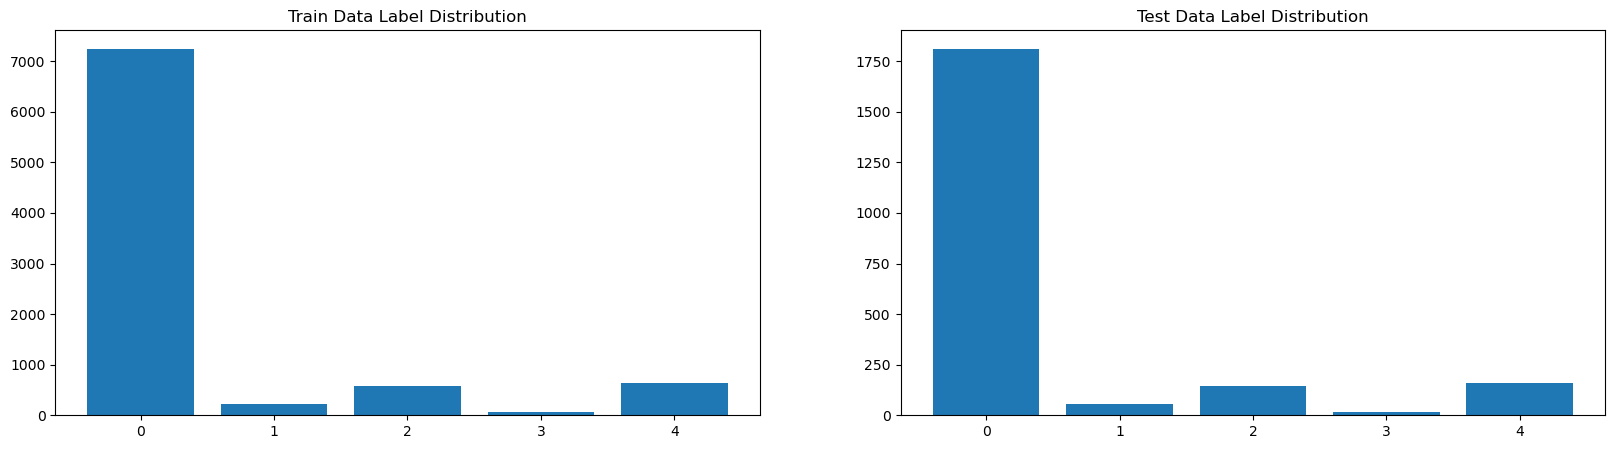

In [50]:
train_sub_value_counts = df_train_sub["label"].value_counts()
test_sub_value_counts = df_test_sub["label"].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].bar(train_sub_value_counts.index, train_sub_value_counts.values)
axs[0].set_title("Train Data Label Distribution")
axs[1].bar(test_sub_value_counts.index, test_sub_value_counts.values)
axs[1].set_title("Test Data Label Distribution")

In [51]:
print("Class Proportions")
train_sub_value_counts / np.sum(train_sub_value_counts)

Class Proportions


0    0.827775
4    0.073435
2    0.066126
1    0.025354
3    0.007309
Name: label, dtype: float64

Yes, we are good. It still has the same distribution.
Next we confirm if there are no missing values in the data.

In [52]:
print(f"Missing Values in train set: {df_train_sub.isnull().values.any()}")
print(f"Missing Values in test set: {df_test_sub.isnull().values.any()}")

Missing Values in train set: False
Missing Values in test set: False


## EDA
Let us start by visualizing a few examples of each heart beat type.

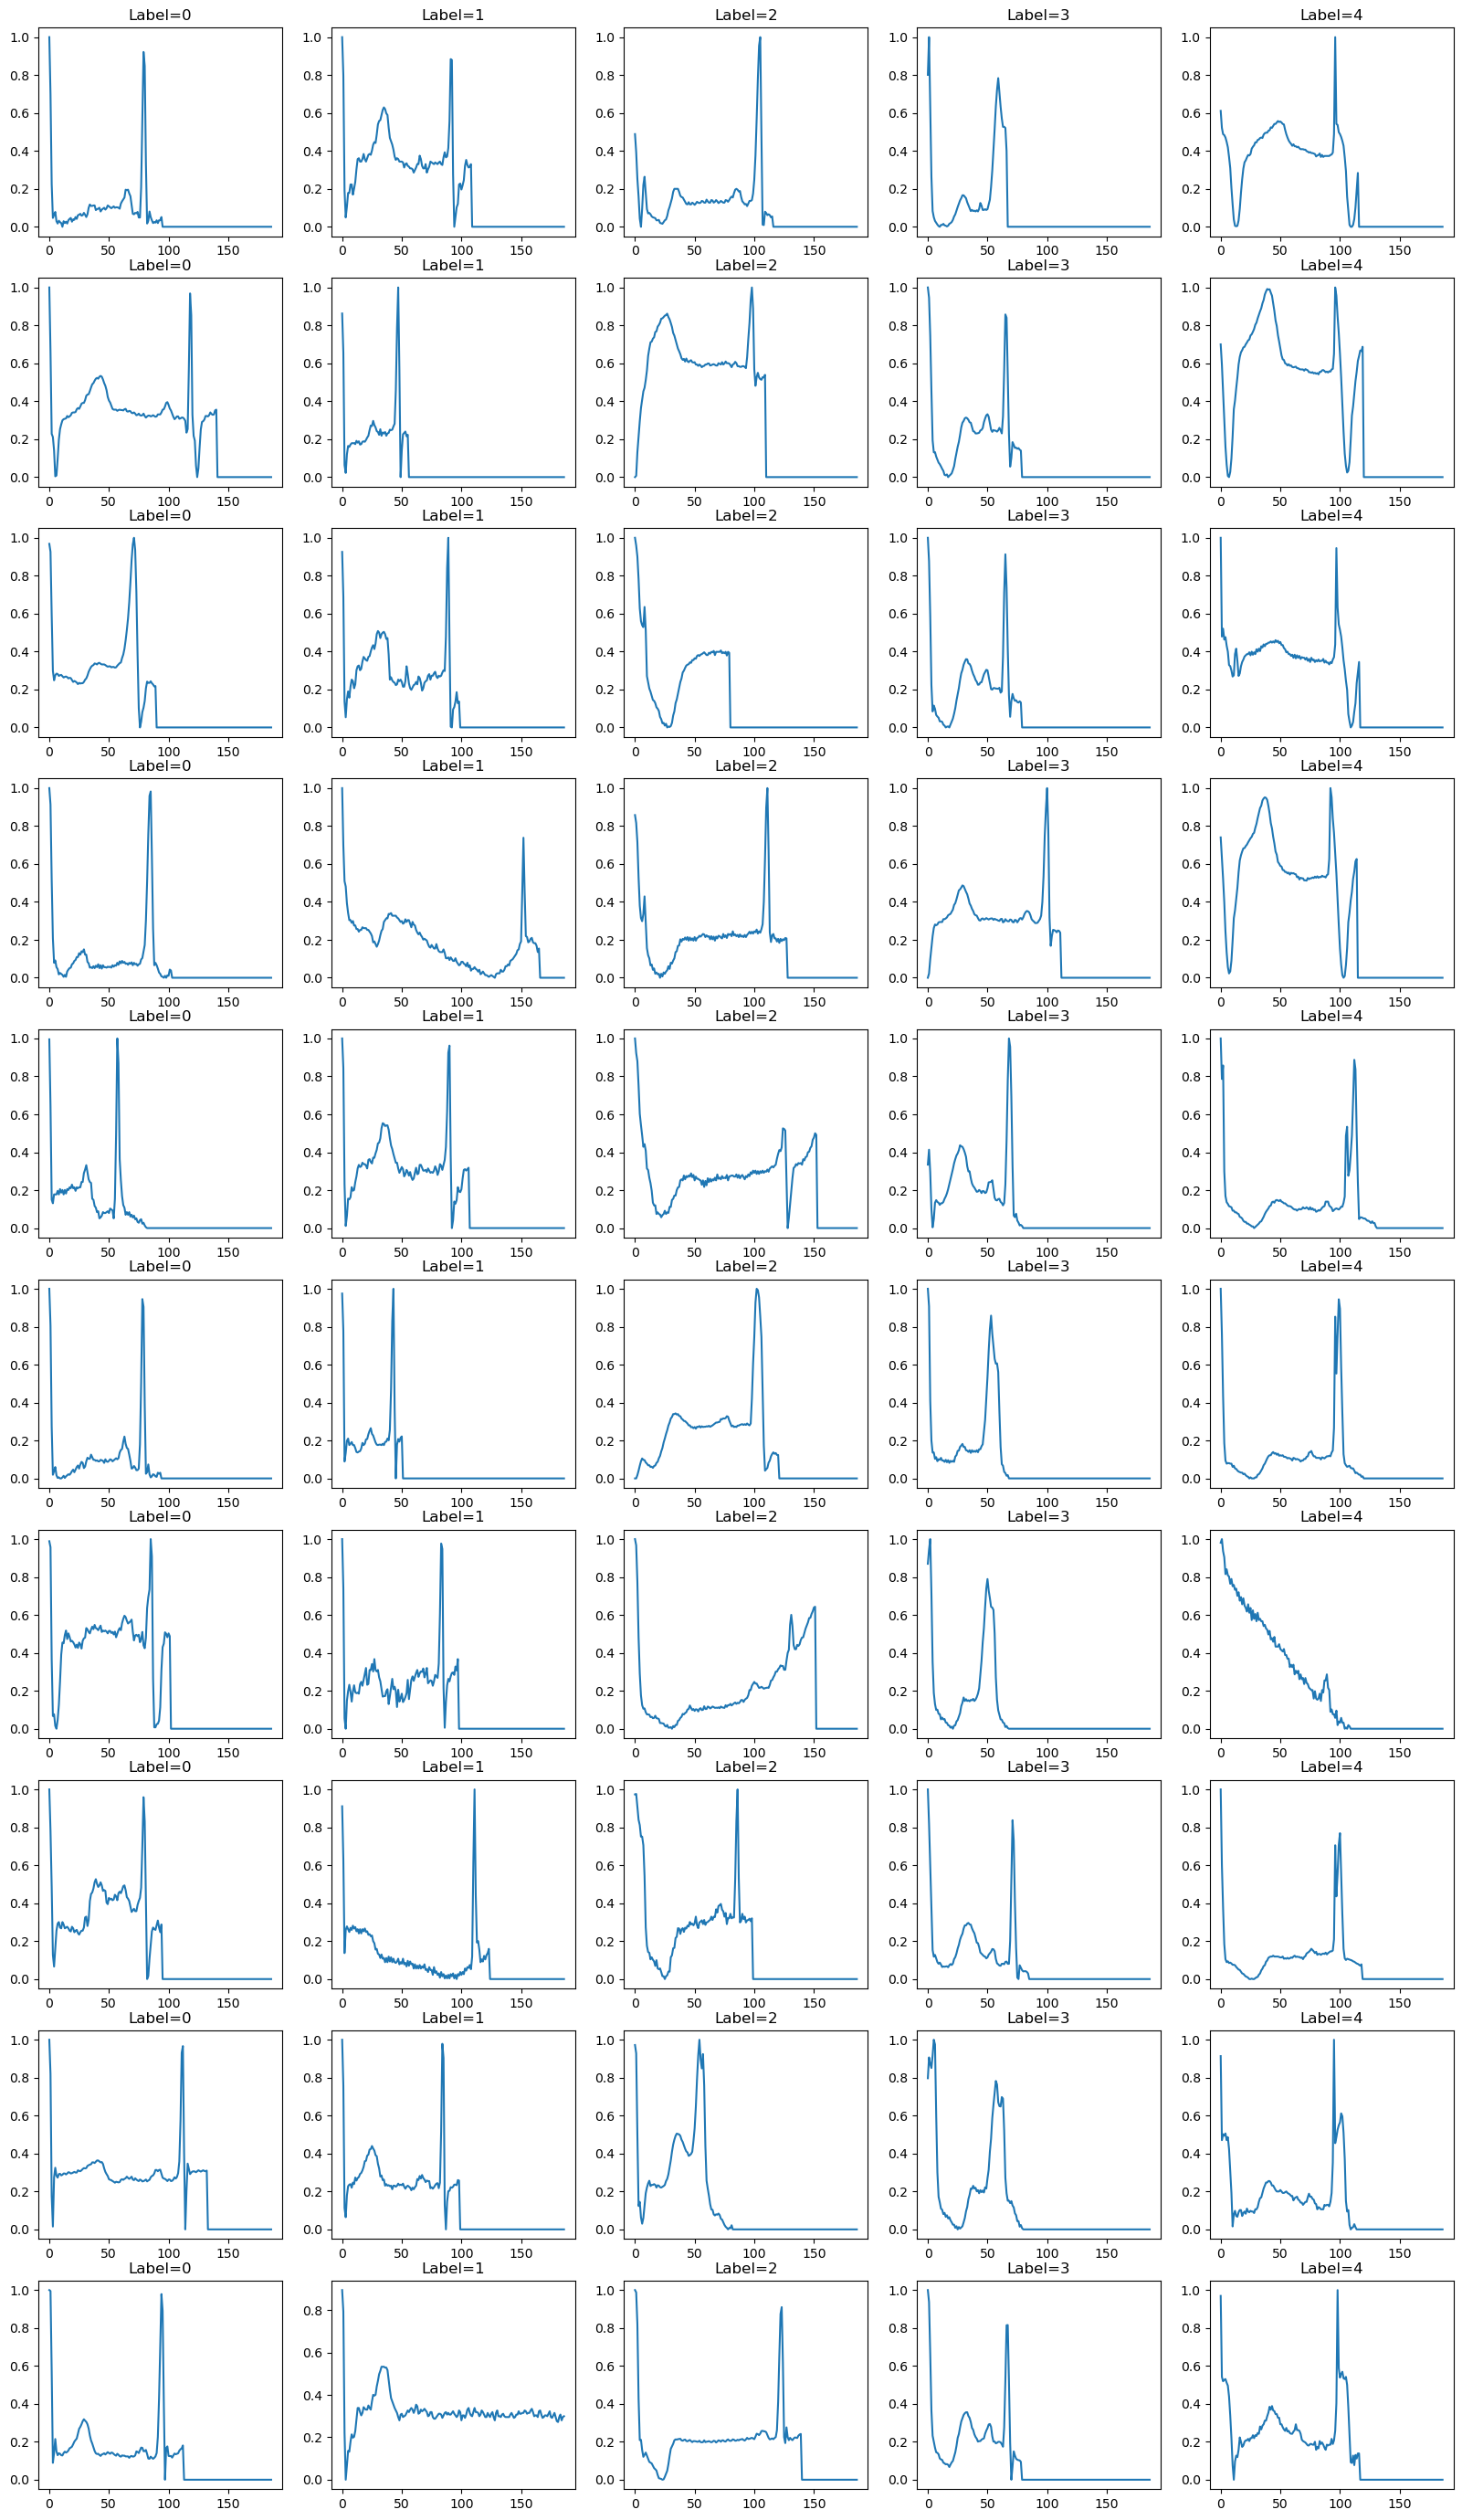

In [53]:
labels = [0, 1, 2, 3, 4]

n_to_view = 10
fig, axs = plt.subplots(n_to_view, 5, figsize=(20, 35))
for label in labels:
    label_df = df_train_sub[df_train_sub["label"] == label]
    for i in range(n_to_view):
        data = label_df.drop(['label'], axis=1).iloc[i].values
        axs[i, label].plot(range(len(data)), data)
        axs[i, label].set_title(f"Label={label}")

We could observe that in these examples, the only one that have consistency in visual appearance is the normal heartbeat (class 0). The other classes look rather inconsistent, sometimes completely out of place. Within class 0, every example has the large spike in a different spot. This suggest that it is not a consistent feature to examine. Almost every example is also zero padded at the end, meaning that the later features in the time series are unlikely to be as relevant as the early features.

In order to introduce some summary statistics of the waveform into the datasets, the mean and standard deviation of each time series will be added as additional features.

In [54]:
train_means = df_train_sub.drop(['label'], axis=1).mean(axis=1)
train_stds = df_train_sub.drop(['label'], axis=1).std(axis=1)
df_train_sub["mean"] = train_means
df_train_sub["std"] = train_stds

test_means = df_test_sub.drop(['label'], axis=1).mean(axis=1)
test_stds = df_test_sub.drop(['label'], axis=1).std(axis=1)
df_test_sub["mean"] = test_means
df_test_sub["std"] = test_stds

Let us take a look at the correlation matrix. This might provide us some interesting insight

<AxesSubplot:>

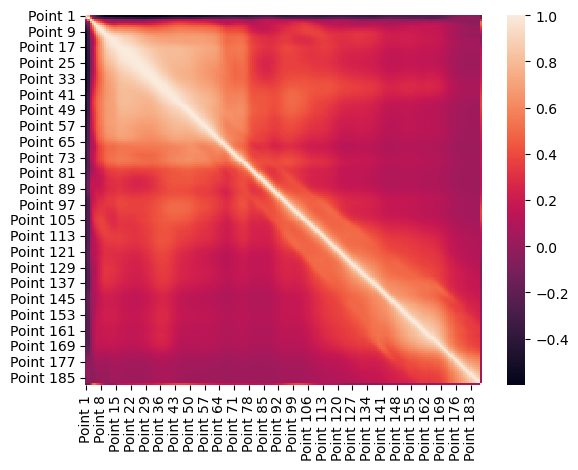

In [55]:
sns.heatmap(df_train.corr())

## Bibliography:

[1] *ECG Heartbeat Categorization Dataset*. (n.d.). Www.kaggle.com. https://www.kaggle.com/datasets/shayanfazeli/heartbeat

[2] *MIT-BIH Arrhythmia Database v1.0.0*. (n.d.). Www.physionet.org. https://www.physionet.org/content/mitdb/1.0.0/

[3] *PTB Diagnostic ECG Database v1.0.0*. (n.d.). Www.physionet.org. https://www.physionet.org/content/ptbdb/1.0.0/

‌